# Probabilistic Numerical Methods

Probabilistic numerical methods solve numerical problems from linear algebra, optimization, quadrature and differential equations using _probabilistic inference_. This approach captures uncertainty arising from finite computational resources and from stochastic input. 

In order to illustrate what PN methods are and how they work consider the following deliberately simple numerical problem.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../probnum.mplstyle')

## A Simple Numerical Problem

Consider the following one-dimensional optimization problem $$\underset{x \in \mathbb{R}}{\operatorname{min}} f(x) = \underset{x \in \mathbb{R}}{\operatorname{min}} \frac{1}{2} ax^2 + bx + c,$$ where $f$ is a quadratic function and we assume $a > 0$. Since $f$ is a strictly convex function there exists a unique minimum given by $$f'(x_*) = 0 \iff x_*=-\frac{b}{a}.$$

In [2]:
import numpy as np
import probnum as pn

# Quadratic objective function
a = 2
b = -1.0
c = 3.0
x_opt = - b / a

def f(x):
    return 0.5 * a * x ** 2 + b * x + c

Now suppose we are not given access to the coefficients, but only the ability to evaluate $f$ and its derivative $f'$ at arbitrary points. We can then evaluate the derivative twice at $x=0$ and $x=1$ to find the parameters $a$ and $b$ or more generally use a numerical method such as gradient descent to solve the problem.

## Introducing Noise

However, what happens if we go one step further and function evaluations are corrupted by additive noise? This is often the case in practice where $f$ might describe a complex physical system or depend on data. Can we still design an efficient algorithm which finds the minimum?

Suppose we only have access to noisy evaluations $$\hat{y} = \hat{f}(x) = \frac{1}{2}(a + \varepsilon_a)x^2 + (b+\varepsilon_b)x + (c + \varepsilon_c)$$  of the objective function $f$ at $x$, where $\varepsilon = (\varepsilon_a, \varepsilon_b, \varepsilon_c) \sim \mathcal{N}(0, \Lambda)$ and $\Lambda \in \mathbb{R}^{3 \times 3}$ symmetric positive definite.

> *Remark*: The $n$-dimensional analogue of this case arises for example in supervised (deep) learning. In large-scale empirical risk minimization the available training data often does not fit into (local) memory, so during optimization only batches of data are considered inducing noise on the objective function and its gradient. Here $\hat{f}$ is analogous to the empirical risk on the current batch.

In [3]:
from probnum import random_variables as rvs

# Noisy objective function
Lambda = np.diag([0.02, 0.01, 0.01])
eps = rvs.Normal(np.zeros(3), Lambda)

def f_hat(x, noise=None):
    if noise is None:
        noise = eps.sample()
    return 0.5 * (a + noise[0]) * x ** 2 + (b + noise[1]) * x + c + noise[2]

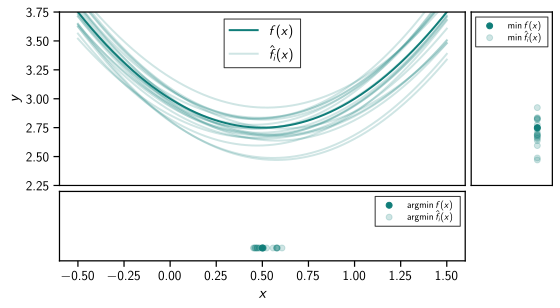

In [4]:
# Random seed
np.random.seed(42)

# Plot objective and noisy evaluations
n_samples = 20
xx = np.linspace(x_opt - 1, x_opt + 1, 1000)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=[8, 4.5], 
                         gridspec_kw={"height_ratios": [2.5, 1], "width_ratios": [5, 1]})
ylim00 = [2.25, 3.75]
ylim10 = [-0.25, 1.1]

# Function, optimal function value and optimum
axes[0, 0].plot(xx, f(xx), label="$f(x)$")
axes[1, 0].scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
axes[0, 1].scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
for i in range(n_samples):
    noise = eps.sample()
    x_opt_noise = -(b + noise[1]) / (a + noise[0])
    if i == 0:
        sample_label = "$\\hat{f}_i(x)$"
        sample_min_label = "$\min \\hat{f}_i(x)$"
        sample_argmin_label = "$\operatorname{argmin} \hat{f}_i(x)$"
    else:
        sample_label = None
        sample_argmin_label = None
        sample_min_label = None
    axes[0, 0].plot(xx, f_hat(xx, noise), color="C0", alpha=0.2, label=sample_label)
    axes[1, 0].scatter(x_opt_noise, 0, color="C0", alpha=0.2, label=sample_argmin_label)
    axes[0, 1].scatter(ylim10[1] + ylim10[0], f_hat(x_opt_noise, noise), color="C0", alpha=0.2,
                      label=sample_min_label)

axes[0, 0].get_xaxis().set_visible(False)
axes[1, 0].get_yaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[1, 1].axis("off")

axes[0, 0].set_ylim(ylim00)
axes[1, 0].set_ylim(ylim10)
axes[0, 1].set_xlim(ylim10)
axes[0, 0].set_ylabel("$y$")
axes[1, 0].set_xlabel("$x$")
axes[0, 0].legend(loc="upper center")
axes[0, 1].legend(loc="upper center", fontsize=10, labelspacing=0)
axes[1, 0].legend(loc="upper right", fontsize=10, labelspacing=0)

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

This makes the optimization problem considerably more difficult depending on the degree of noise. Can we still come up with a computationally efficient and accurate algorithm that makes use of the information we have about the problem? We will do so by designing a custom **probabilistic numerical method**. 

## Components of a PN Method

We will now build up a probabilistic numerical method from its components, which solves the given optimization problem. In a nutshell a PN method consists of *prior knowledge* about the problem (e.g. differentiability), a *policy*, which returns an *action* that collects information about the problem resulting in *observations*. Using statistical inference this leads to a *posterior belief* over the numerical quantity in question. Finally, typically a *stopping criterion* determines, when to terminate.

### Prior Knowledge

A naive strategy to solve the problem given only the ability to evaluate the noisy function $\hat{f}$ could be to simply choose random points on the real axis and return the point of lowest observed function value. However, clearly this is suboptimal since it completely ignores information we have and collect about the problem. For example, we know the latent function is quadratic. 

Further, we might have some idea of where the minimum of the function $f$ lies. This could come from experience, a physical application from which the problem arises or related optimization problems we have solved in the past.

We can combine these two forms of prior information, an inherent property of the problem and a belief over its minimum, into a prior distribution over a random variable modelling the coefficients of the quadratic function. This induces a belief over the optimal function value $f(x_*)$.

In [5]:
# Prior on parameters: a, b, c
mu = np.array([1.5, 0.0, 3.5])
Sigma = 0.05 * np.eye(3)
f_params0 = rvs.Normal(mean=mu, cov=Sigma)
x0 = - f_params0.mean[1] / f_params0.mean[0]

# Induced belief over optimal function value
def f_opt0(f_params0, x):
    x = np.asarray(x).reshape(-1, 1)
    return np.hstack((0.5 * x ** 2, x, np.ones_like(x))) @ f_params0

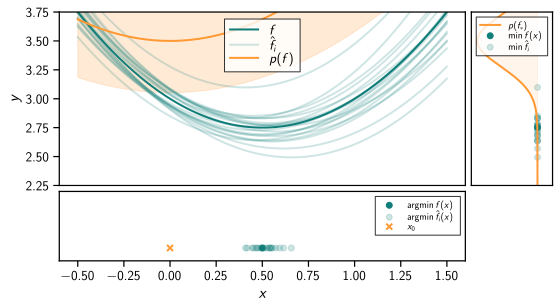

In [6]:
# Random seed
np.random.seed(42)

# Plot objective and noisy evaluations
yy = np.linspace(ylim00[0], ylim00[1], 1000)
f_opt0_mean = f_opt0(f_params0, xx).mean
f_opt0_std = np.sqrt(f_opt0(f_params0, xx).var)
f0_pdf = f_opt0(f_params0, x0).pdf(yy)
f0_pdf_max = np.max(f0_pdf)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=[8, 4.5], 
                         gridspec_kw={"height_ratios": [2.5, 1], "width_ratios": [5, 1]})

# Function, optimal function value and optimum
axes[0, 0].plot(xx, f(xx), label="$f$")
axes[1, 0].scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
axes[0, 1].scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
for i in range(n_samples):
    noise = eps.sample()
    x_opt_noise = -(b + noise[1]) / (a + noise[0])
    if i == 0:
        sample_label = "$\\hat{f}_i$"
        sample_min_label = "$\min \\hat{f}_i$"
        sample_argmin_label = "$\operatorname{argmin} \hat{f}_i(x)$"
    else:
        sample_label = None
        sample_argmin_label = None
        sample_min_label = None
    axes[0, 0].plot(xx, f_hat(xx, noise), color="C0", alpha=0.2, label=sample_label)
    axes[1, 0].scatter(x_opt_noise, 0, color="C0", alpha=0.2, label=sample_argmin_label)
    axes[0, 1].scatter(ylim10[1] + ylim10[0], f_hat(x_opt_noise, noise), color="C0", alpha=0.2,
                      label=sample_min_label)
axes[0, 1].plot(ylim10[1] + ylim10[0] - f0_pdf / f0_pdf_max, yy, color="C1", label="$p(f_*)$")
axes[0, 1].fill_betweenx(y=yy, 
                         x1=ylim10[1] + ylim10[0] - f0_pdf / f0_pdf_max, 
                         x2=ylim10[1] + ylim10[0],
                         color="C1", alpha=0.1)
axes[1, 0].scatter(x0, 0, color="C1", marker="x", label="$x_0$")
axes[0, 0].plot(xx, f_opt0_mean, color="C1", label="$p(f)$")
axes[0, 0].fill_between(x=xx, y1=f_opt0_mean - 2 * f_opt0_std, y2=f_opt0_mean + 2 * f_opt0_std,
                       color="C1", alpha=0.2)

axes[0, 0].get_xaxis().set_visible(False)
axes[1, 0].get_yaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[1, 1].axis("off")

axes[0, 0].set_ylim(ylim00)
axes[1, 0].set_ylim(ylim10)
axes[0, 1].set_xlim(ylim10)
axes[0, 0].set_ylabel("$y$")
axes[1, 0].set_xlabel("$x$")
axes[0, 0].legend(loc="upper center", labelspacing=0)
axes[0, 1].legend(loc="upper center", fontsize=10, labelspacing=0)
axes[1, 0].legend(loc="upper right", fontsize=10, labelspacing=0)

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

We would like to use this prior information to solve the optimization problem in question. In order to do so we need to collect information about the problem, which we do by evaluating $\hat{f}$ at chosen points $x_i$. 

### Policy

In order to collect information about the problem we need to decide where to evaluate the (noisy) objective function $\hat{f}$. This is done via a _policy_ $\pi$. In principle this can be any function which maps to the domain of $\hat{f}$, however it is sensible to use the model of the problem our algorithm is iteratively constructing. This is called a model-based policy.

In [7]:
def random_walk(f_params0, region=(-0.5, 1.5)):
    """A uniform random walk policy."""
    return np.random.uniform(low=region[0], high=region[1])

def greedy(f_params0):
    """Greedy model-based policy."""
    a = f_params0.mean[0]
    b = f_params0.mean[1]
    return - b / a
                  
def sampling(f_params0):
    """Sampling model-based policy."""
    abc_sample = f_params0.sample()
    a_sample = abc_sample[0]
    b_sample = abc_sample[1]
    return - b_sample / a_sample

def entropy_search(f_params0):
    """Entropy search."""
    return np.inf

In [8]:
print(f"Suggested evaluation points by a...\n \t...random walk policy:\t\t{random_walk(f_params0):.2f},\n \t" + 
      f"...greedy policy:\t\t{greedy(f_params0):.2f}, \n \t" +
      f"...sampling policy:\t\t{sampling(f_params0):.2f}, and \n \t" +
      f"...entropy search:\t\t{entropy_search(f_params0):.2f}.")

Suggested evaluation points by a...
 	...random walk policy:		0.44,
 	...greedy policy:		-0.00, 
 	...sampling policy:		0.09, and 
 	...entropy search:		inf.


### Action and Observation

We now use our policy to collect observations about the problem by evaluating the objective function at the suggested evaluation point(s).

In [9]:
def observe(objective, x):
    """Evaluate the objective at a given location."""
    return objective(x)

### Inference Step

Given the noise model we can compute the posterior distribution over the parameters $(a, b, c)$ given a set of actions $X=(x_1, \dots, x_k)$ using Bayes' theorem. To that end, let
$$\Phi = \begin{pmatrix}\frac{1}{2}x_1^2 & \cdots &  \frac{1}{2}x_k^2 \\ x_1 & \cdots & x_k\\1 & \cdots & 1 \end{pmatrix}$$
be the feature vector for a single action $x$. We have

#### Prior

$$
(a, b, c) \sim \mathcal{N}(\mu, \Sigma)
$$

#### Likelihood

$$
p(y \mid a, b, c, x) = \mathcal{N}\big(y; f(x), \Phi^\top \Lambda \Phi\big)
$$

#### Posterior

$$
p(a, b, c \mid x, y) = \mathcal{N}((a,b,c); m, S)
$$
where
$$
\begin{aligned}
m &= \mu + \Sigma \Phi \big(\Phi^\top (\Sigma + \Lambda) \Phi \big)^{-1}(y - \Phi^\top \mu)\\
S &= \Sigma - \Sigma \Phi \big(\Phi^\top (\Sigma + \Lambda) \Phi \big)^{-1} \Phi^\top \Sigma
\end{aligned}
$$

In [10]:
def infer_posterior(f_params, x, y):
    """Compute the parameters of the posterior distribution."""
    # Feature vector
    x = np.asarray(x).reshape(1, -1)
    Phi = np.vstack((0.5 * x ** 2, x, np.ones_like(x)))
    
    # Mean and covariance
    mu = f_params.mean
    Sigma = f_params.cov
    
    # Gram matrix
    gram = Phi.T @ (Sigma + Lambda) @ Phi
    
    # Posterior Mean
    m = mu + Sigma @ Phi @ np.linalg.solve(gram, y - Phi.T @ mu)
    
    # Posterior Covariance
    S = Sigma - Sigma @ Phi @ np.linalg.solve(gram, Phi.T @ Sigma)
    
    return m, S

Note, for simplicity we assumed the noise level of the data is known. Usually in practice this is not the case. However, one can actually infer the noise level using the probabilistic framework from the data.

### Stopping Criteria

In [11]:
def stopping_criterion(f_params0, x_opt0, current_iter, maxiter=10000, tol=10**-3):
    """Convergence criteria."""
    if current_iter >= maxiter:
        return True, "maxiter"
    elif np.trace(f_params0.cov) < tol:
        return True, "trace_cov"
    else:
        return False, None

## Putting It All Together

In [12]:
def probsolve_qp(f, 
                 f_params0,
                 policy=sampling, 
                 stopping_criterion=stopping_criterion,
                 callback=None
                ):
    """
    Probabilistic 1D Quadratic Optimization.
    
    PN method solving unconstrained one-dimensional (noisy) quadratic 
    optimization problems only needing access to function evaluations.
    
    Parameters
    ----------
    f : callable
    f_params0 : pn.RandomVariable
    policy : callable
    stopping_criterion : callable
    callback : callable
    
    Returns
    -------
    x_opt : np.ndarray
    f_opt : pn.RandomVariable
    f_params : pn.RandomVariable
    info : dict
    """
    # Initialization
    iteration = 0
    x_opt0 = - f_params0.mean[1] / f_params0.mean[0]
    
    # Iterate until convergence
    while True:
        
        # Stopping criterion
        has_converged, conv_crit = stopping_criterion(f_params0, x_opt0, iteration)
        if has_converged:
            break
        
        # Policy
        x = policy(f_params0)
        
        # Observation
        y = observe(f_hat, x)
        
        # Inference
        post_mean, post_cov = infer_posterior(f_params0, x, y)
        f_params0 = rvs.Normal(mean=post_mean, cov=post_cov)
        
        # Callback function
        callback(x, y, f_params0)
        
        # Belief over optimal function value and optimum
        x_opt0 = - f_params0.mean[1] / f_params0.mean[0]
        f_opt0 = np.array([0.5 * x_opt0 ** 2, x_opt0, 1]).T @ f_params0
        
        iteration += 1

    # Information on convergence
    info = {
        "iter" : iteration,
        "conv_crit" : conv_crit
    }
        
    return x_opt0, f_opt0, f_params0, info

In [13]:
np.random.seed(42)

# Callback function to return iterates
x_iterates = []
y_iterates = []
f_params0_iterates = []

def callback(x, y, f_params):
    x_iterates.append(x)
    y_iterates.append(y)
    f_params0_iterates.append(f_params)
    

# Solve noisy quadratic optimization problem
x_opt_post, f_opt_post, f_params_post, info = probsolve_qp(f_hat, 
                                                           f_params0, 
                                                           policy=random_walk,
                                                           callback=callback)

# Print results
print(f"Estimated optimum: {x_opt_post:.4f} vs. true optimum: {x_opt}")
print(f"Estimated optimal value: {f_opt_post.mean:.4f} " + u"\u00B1" 
      +  f" {2 * f_opt_post.std:.4f} vs. true optimal value: {f(x_opt)}")
print(info)

Estimated optimum: 0.4953 vs. true optimum: 0.5
Estimated optimal value: 2.7466 ± 0.0108 vs. true optimal value: 2.75
{'iter': 1079, 'conv_crit': 'trace_cov'}


In [29]:
# Animation parameters
total_frames = 20

# Set up figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=[8, 4.5], 
                         gridspec_kw={"height_ratios": [2.5, 1], "width_ratios": [5, 1]})
plt.tight_layout(h_pad=0, w_pad=0)
plt.close()

# Plot data
yy = np.linspace(ylim00[0], ylim00[1], 1000)


def animate(i):
    # Clear axes
    axes[0, 0].cla()
    axes[0, 1].cla()
    axes[1, 0].cla()
    axes[1, 1].cla()
    
    # Select data
    alg_iter_list = np.concatenate([np.arange(0, 10), 
                                    np.round(np.linspace(10, len(x_iterates) - 1, 
                                                         total_frames - 10)).astype(int)])
    alg_iter = alg_iter_list[i]
    x = x_iterates[alg_iter]
    y = y_iterates[alg_iter]
    f_params0 = f_params0_iterates[alg_iter]
    
    # Plot objective and noisy evaluations
    f_opt0_mean = f_opt0(f_params0, xx).mean
    f_opt0_std = np.sqrt(f_opt0(f_params0, xx).var)
    x_opt0 = - f_params0.mean[1] / f_params0.mean[0]
    f0_pdf = f_opt0(f_params0, x_opt0).pdf(yy)
    f0_pdf_max = np.max(f0_pdf)

    # Function, optimal function value and optimum
    axes[0, 0].plot(xx, f(xx), label="$f$")
    axes[1, 0].scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
    axes[0, 1].scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
    axes[0, 1].plot(ylim10[1] + ylim10[0] - f0_pdf / f0_pdf_max, yy, color="C1", label="$p(f_*)$")
    axes[0, 1].fill_betweenx(y=yy, 
                             x1=ylim10[1] + ylim10[0] - f0_pdf / f0_pdf_max, 
                             x2=ylim10[1] + ylim10[0],
                             color="C1", alpha=0.1)
    axes[1, 0].scatter(x_opt0, 0, color="C1", label="$x_*$")
    axes[1, 0].scatter(x, 0, color="C3", marker="x", label=f"action $x_{{{alg_iter}}}$")
    axes[0, 0].plot(xx, f_opt0_mean, color="C1", label="$p(f)$")
    axes[0, 0].fill_between(x=xx, y1=f_opt0_mean - 2 * f_opt0_std, y2=f_opt0_mean + 2 * f_opt0_std,
                           color="C1", alpha=0.2)


    axes[0, 0].legend(loc="upper center", labelspacing=0)
    axes[0, 1].legend(loc="upper center", fontsize=10, labelspacing=0)
    axes[1, 0].legend(loc="upper right", fontsize=10, labelspacing=0)
    
    axes[0, 0].get_xaxis().set_visible(False)
    axes[1, 0].get_yaxis().set_visible(False)
    axes[0, 1].get_yaxis().set_visible(False)
    axes[0, 1].get_xaxis().set_visible(False)
    axes[1, 1].axis("off")

    axes[0, 0].set_ylim(ylim00)
    axes[1, 0].set_ylim(ylim10)
    axes[0, 1].set_xlim(ylim10)
    axes[0, 0].set_ylabel("$y$")
    axes[1, 0].set_xlabel("$x$")

In [30]:
from matplotlib import animation, rc
from IPython.display import HTML

# Animation
anim = animation.FuncAnimation(fig, 
                               func=animate,
                               frames=total_frames, 
                               interval=2000,
                               repeat_delay=5000,
                               blit=False)

plt.close()
HTML(anim.to_jshtml())

## Some Advantages of a PN Method

- Incorporation of prior knowledge

### Hyperparameter Optimization

- set degrees of freedom / parameters of numerical methods automatically / in a principled way using the Bayesian formalism
- Learn the noise level from the data via model evidence

### Solution of Related Problems

## Outlook


### Connections to 
- Inference = Gaussian process regression
- Bayesian Optimization
- Probabilistic Linear Solver <a href="../automod/probnum.linalg.problinsolve.html#probnum.linalg.problinsolve">`probnum.linalg.problinsolve`</a>
    - Krylov space policy coincides with greedy policy in 1D case

### Implement a PN Method in ProbNum
- Development Tutorial

If you want to try out these tutorials for yourself, you can download the notebooks from the
[GitHub repository](https://github.com/probabilistic-numerics/probnum/tree/master/docs/source/tutorials).

## Notes

### Variant 1: $p(x)$

- termination criterion
- output random variable $x$
- requires knowledge of $a,b$ not just $f(x)$

### Variant 2: $p(f)$

- Inference easy with prior over $a,b,c$
- Noise inference possible via model evidence
- policy
    - random walk
    - sampling: $(a,b,c) \sim posterior$ results in $x_i = -\frac{b}{a}$
    - sampling based but with Krylov dynamics, i.e. $x_i = -\frac{ax_{i-1} - b}{a}$
    - (approximation to) [expected improvement](https://arxiv.org/pdf/1807.02811.pdf) ($\approx$ postvar / mean => high variance: exploration, small mean: exploitation (close to minimum)
- stopping criterion
    - posterior contraction of $f(x_i)$
- posterior on $x$ only has [pdf](https://rstudio-pubs-static.s3.amazonaws.com/287838_7c982110ffe44d1eb5184739c5724926.html) and sample function
- Gaussian approximation for $x$ exists (but is potentially arbitrarily bad)
- Bayesian Optimization analogy